In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
from multiprocessing import Pool
# from scipy import optimize as op
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
#     'font.size' : 14.4,
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%matplotlib notebook

In [4]:
df_NP = pd.read_csv('data/Au_NP.csv')
df_base = pd.read_csv('data/HAuCl4_solution.csv')
df_epsilon = pd.read_csv('data/epsilon_bulk_Au.csv')

def access(df,lam,key):
    lam_0 = df['lambda'][0]
    i = int(lam - lam_0)
    return df[key][i]

In [5]:
def r_chi2(func, xdata, ydata, args, ddof=0):
    '''
    func(x, *args)
    '''
    if ddof == 0:
        ddof = len(xdata) - len(args)
    return np.sum((ydata - func(xdata, *args))**2)/ddof

def make_args_list(args):
    '''
    args is a list of arrays: each of them contains the possible values for that parameter
    '''
    lens = [len(a) for a in args]
    return np.array(np.meshgrid(*args)).T.reshape(np.product(lens),len(lens))


def r_chi2_map(func, xdata, ydata, args_list, ofile='',columns=['eps_m','f','chi2']):
    df = pd.DataFrame(data=[],columns=columns)
    for args in tqdm(args_list):
        chi2 = r_chi2(func,xdata,ydata,args)
        df.loc[len(df)] = list(args) + [chi2]
    if ofile != '':
        df.to_csv(ofile,index=False)
    return df

In [6]:
import scipy.constants as cts

## parameters from Aschkrof-Mermin
n_e = 5.9e28
omega_p = np.sqrt(n_e*cts.e**2/(0.99*cts.m_e*cts.epsilon_0))
gamma_b = 1./9.3e-15
v_F = 1.4e06*10**9
z = 0.01*10**9 # thickness of the sample in nm

In [7]:
def eps_SC(lam,R):
    omega = 2*np.pi*cts.c*10**9/lam
    
    eps_1_b = access(df_epsilon,lam,'eps_1')
    eps_2_b = access(df_epsilon,lam,'eps_2')
    
    gamma = gamma_b + np.pi/4*v_F/R
    
    eps_1 = eps_1_b + 1/((omega/omega_p)**2 + (gamma_b/omega_p)**2) - 1/((omega/omega_p)**2 + (gamma/omega_p)**2)
    
    eps_2 = eps_2_b - gamma_b/omega/((omega/omega_p)**2 + (gamma_b/omega_p)**2) + gamma/omega/((omega/omega_p)**2 + (gamma/omega_p)**2)
    
    return eps_1, eps_2

@np.vectorize
def absorbance_SC(lam,eps_m,rho,R):
    eps_1, eps_2 = eps_SC(lam,R)
    return 18*np.pi*z/(np.log(10)*lam)*eps_m**1.5*rho*(4*np.pi*R**3/3)*eps_2/((eps_1 + 2*eps_m)**2 + eps_2**2)


@np.vectorize
def absorbance_SCf(lam,eps_m,f,R):
    eps_1, eps_2 = eps_SC(lam,R)
    return 18*np.pi*z/(np.log(10)*lam)*eps_m**1.5*f*eps_2/((eps_1 + 2*eps_m)**2 + eps_2**2)

def absorbance_SCf_Rdist(lam,eps_m,f,R_values,R_probs):
    '''
    Assumes np.sum(R_probs) = 1
    '''
    absorb = 0.
    for i,R_v in enumerate(R_values):
        absorb += absorbance_SCf(lam,eps_m,f,R_v)*R_probs[i]
    return absorb


def r_chi2_SCf_pool(func,args_list,columns=['eps_m','f','R','chi2'],ofile=''):    
    p = Pool(6)
    values = p.map(func, tqdm(args_list))
    
    df = pd.DataFrame(data=values,columns=columns)
    
    if ofile != '':
        df.to_csv(ofile,index=False)
    return df

@np.vectorize
def absorbance_SCsf(lam,eps_m,f,R,e):
    if e < 0.001:
        return absorbance_SCf(lam,eps_m,f,R)
    
    eps_1, eps_2 = eps_SC(lam,R)
    e1 = 1./e
    L1 = (e1**2 - 1)*(0.5*e1*np.log((1 + e)/(1 - e)) - 1)
    L2 = 0.5*(1. - L1)
    s1 = eps_2/L1**2/((eps_1 + eps_m*(1 - L1)/L1)**2 + eps_2**2)
    s2 = eps_2/L2**2/((eps_1 + eps_m*(1 - L2)/L2)**2 + eps_2**2)
    return 2./3.*np.pi*z/(np.log(10)*lam)*eps_m**1.5*f*(s1 + 2*s2)

@np.vectorize
def aspect_ratio(e):
    return 1./np.sqrt(1 - e**2)

@np.vectorize
def e_from_aspr(ar):
    return(np.sqrt(1 - 1./ar**2))

@np.vectorize
def absorbance_SCsf_Rdist(lam,eps_m,f,R_values,R_probs,e):
    absorb = 0.
    for i,R_v in enumerate(R_values):
        absorb += absorbance_SCsf(lam,eps_m,f,R_v,e)*R_probs[i]
    return absorb

@np.vectorize
def absorbance_SCf_cauchy(lam,A,B,f,R):
    eps_m = (A + B*1./lam**2)**2
    return absorbance_SCf(lam,eps_m,f,R)

In [8]:
def integrate(df,free_axes,int_axis,v_min,v_max):  ## this way it does not work
    keys = df.keys()
    new_df = pd.DataFrame(data=[],columns=[keys[j] for j in free_axes] + ['chi2'])
    old_pars = []
    pars = []
    for i in tqdm(range(len(df))):
        v = df[keys[int_axis]][i]
        if v >= v_min and v <= v_max:
            pars = [df[keys[j]][i] for j in free_axes]
            found = False
            for h in range(1,len(old_pars)+1):
                p = old_pars[len(old_pars) - h]
                if p == pars:
                    new_df['chi2'][len(old_pars) - h] += df['chi2'][i]
                    found = True
                    break
            if not found:
                old_pars.append(pars)
                new_df.loc[len(new_df)] = pars + [df['chi2'][i]]
    
    return new_df

def cut(df,free_axes,int_axis,v_t):
    keys = df.keys()
    new_df = pd.DataFrame(data=[],columns=[keys[j] for j in free_axes] + ['chi2'])
    first_time = True
    pars = []
    for i in tqdm(range(len(df))):
        v = df[keys[int_axis]][i]
        if first_time:
            if v >= v_t:
                first_time = False
                v_t = v
        if not first_time:
            if v == v_t:
                pars = [df[keys[j]][i] for j in free_axes]
                new_df.loc[len(new_df)] = pars + [df['chi2'][i]]
    
    return new_df, v_t

def marginal_likelihood(df,key,coeff=1):
    values = []
    likelihood = []
    
    for i in tqdm(range(len(df))):
        value = df[key][i]
        found = False
        for j,v in enumerate(values):
            if v == value:
                likelihood[j] += np.exp(-df['chi2'][i]*coeff)
                found = True
                break
        if not found:
            values.append(value)
            likelihood.append(np.exp(-df['chi2'][i]*coeff))
            
    s = np.sum(likelihood)
    return np.array(values), np.array(likelihood)/s

In [9]:
eps_m = 2.044
f = 2.605e-6
R = 5.117

lams = np.arange(450,575)
As = np.array([access(df_NP,lam,'A') for lam in lams])

# Cauchy correction

<IPython.core.display.Javascript object>


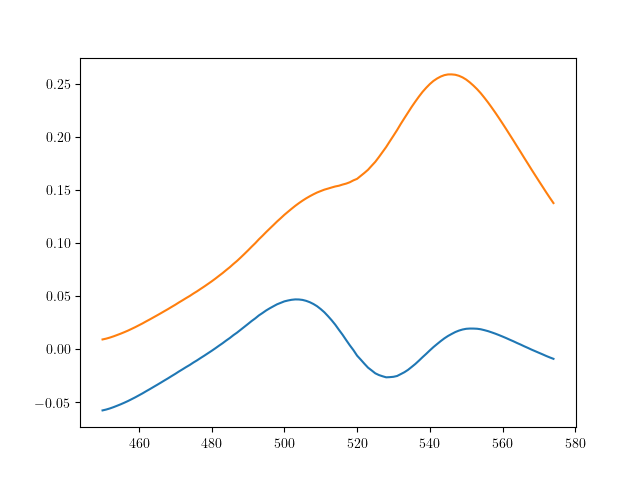

In [19]:
A = 1.3199
# A = eps_m**2
B = 6878

fig,ax = plt.subplots()

ax.plot(lams, As - absorbance_SCf(lams,eps_m,f,R))
ax.plot(lams, As - absorbance_SCf_cauchy(lams,A,B,f,R))


# Montecarlo descent

In [13]:
def montecarlo_descent(func,xdata,ydata,p0,p_range,maxsteps=1000,save_df=None,T = 0,grain=100):
    '''
    p_range is an array of (min,max) values for the params
    '''
    n_params = len(p0)
    p = p0
    E0 = r_chi2(func,xdata,ydata,p)
    if type(save_df) != type(None):
        save_df.loc[len(save_df)] = list(p) + [E0]
    
    for step in tqdm(range(maxsteps)):
        # choose a parameter to move
        i = np.random.choice(np.arange(n_params))
        thrust = np.random.choice([-1,1])*(p_range[i][1] - p_range[i][0])/grain
        p[i] += thrust
        E = r_chi2(func,xdata,ydata,p)
        
        if type(save_df) != type(None):
            save_df.loc[len(save_df)] = list(p) + [E]
            
        if E <= E0:
            E0 = E
        elif T > 0 and np.random.uniform(0,1) < np.exp(-(E - E0)/T):
            E0 = E
        else:
            p[i] -= thrust
            
    return p, E0

## SCf

In [67]:
df = pd.DataFrame(data=[],columns=['eps_m','f','R','r_chi2'])

p0 = np.array([2,
                2e-6,
                10])
p_range = np.array([[1.7,2.5],
                    [1e-6,4e-6],
                    [2,20]])

popt,chi_min = montecarlo_descent(absorbance_SCf,lams,As,p0,p_range,maxsteps=10000,save_df=df,grain=1000,T=0.00001)
i_min = np.argmin(np.array(df['r_chi2']))
popt_scf = df.values[i_min][:-1]
print(popt_scf,chi_min)

100%|██████████| 10000/10000 [01:15<00:00, 132.89it/s]

[2.044e+00 2.606e-06 5.122e+00] 0.0008160250744328469


In [68]:
df.to_csv('../../large_files/MCdescent_SCf_T0.00001.csv')

<IPython.core.display.Javascript object>


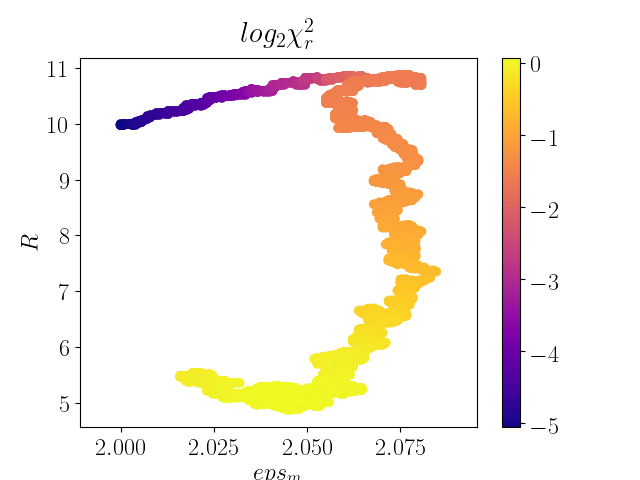

Text(0.5, 1.0, '$log_2\\chi_r^2$')

In [69]:
keyx = 'eps_m'
keyy = 'R'

plt.figure()
# plt.plot(df[keyx],df[keyy])
plt.scatter(df[keyx],df[keyy],c=-np.log(np.array(df['r_chi2'])/chi_min)/np.log(2),cmap='plasma')
plt.colorbar()
plt.xlabel('$%s$' %keyx)
plt.ylabel('$%s$' %keyy)
plt.title(r'$log_2\chi_r^2$')

<IPython.core.display.Javascript object>


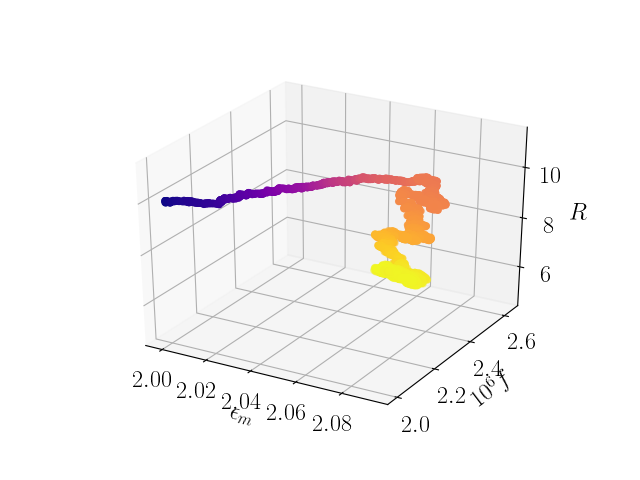

Text(0.5, 0, '$R$')

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['eps_m'],10**6*np.array(df['f']),df['R'],c=-np.log(np.array(df['r_chi2'])/chi_min)/np.log(2),cmap='plasma')
ax.set_xlabel(r'$\epsilon_m$')
ax.set_ylabel('$10^6f$')
ax.set_zlabel('$R$')

## SCsf

In [70]:
df = pd.DataFrame(data=[],columns=['eps_m','f','R','e','r_chi2'])

p0 = np.array([2,
               2e-6,
               10,
               0.1])
p_range = np.array([[1.7,2.5],
                    [1e-6,4e-6],
                    [2,20],
                    [0,0.5]])

popt,chi_min = montecarlo_descent(absorbance_SCsf,lams,As,p0,p_range,maxsteps=10000,save_df=df,grain=1000,T=0.00001)
chi_min = np.min(df['r_chi2'])
i_min = np.argmin(np.array(df['r_chi2']))
popt_scsf = df.values[i_min][:-1]
print(popt_scsf,chi_min)

100%|██████████| 10000/10000 [01:22<00:00, 121.64it/s]

[2.0448e+00 2.6000e-06 5.1760e+00 5.6000e-02] 0.0007814857847668133


In [71]:
df.to_csv('../../large_files/MCdescent_SCsf_T0.00001.csv')

<IPython.core.display.Javascript object>


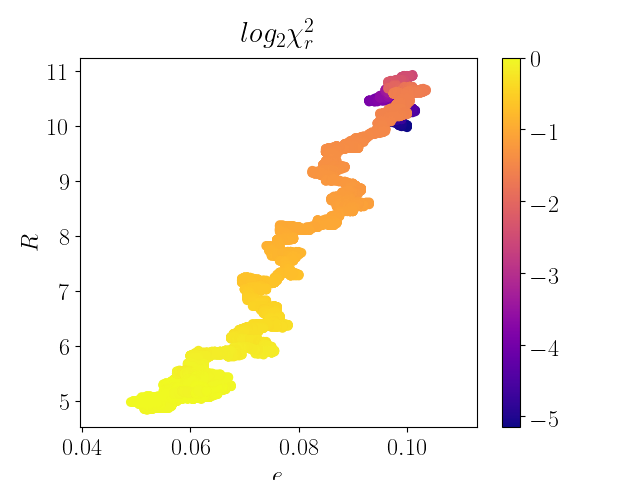

Text(0.5, 1.0, '$log_2\\chi_r^2$')

In [72]:
keyx = 'e'
keyy = 'R'

plt.figure()
# plt.plot(df[keyx],df[keyy])
plt.scatter(df[keyx],df[keyy],c=-np.log(np.array(df['r_chi2'])/chi_min)/np.log(2),cmap='plasma')
plt.colorbar()
plt.xlabel('$%s$' %keyx)
plt.ylabel('$%s$' %keyy)
plt.title(r'$log_2\chi_r^2$')

## SCf Cauchy

In [73]:
df = pd.DataFrame(data=[],columns=['A','B','f','R','r_chi2'])

p0 = np.array([1.33,
               6878,
               2e-6,
               10])
p_range = np.array([[1.2,1.6],
                    [2000,10000],
                    [1e-6,4e-6],
                    [2,20]])

popt,chi_min = montecarlo_descent(absorbance_SCf_cauchy,lams,As,p0,p_range,maxsteps=10000,save_df=df,grain=1000,T=0.00001)
chi_min = np.min(df['r_chi2'])
i_min = np.argmin(np.array(df['r_chi2']))
popt_scf_cauchy = df.values[i_min][:-1]
print(popt_scf_cauchy,chi_min)

100%|██████████| 10000/10000 [03:09<00:00, 52.75it/s]

[1.4076e+00 8.0700e+03 2.5670e-06 5.1220e+00] 0.000890710070466813


In [74]:
df.to_csv('../../large_files/MCdescent_SCf_cauchy_T0.00001.csv')

<IPython.core.display.Javascript object>


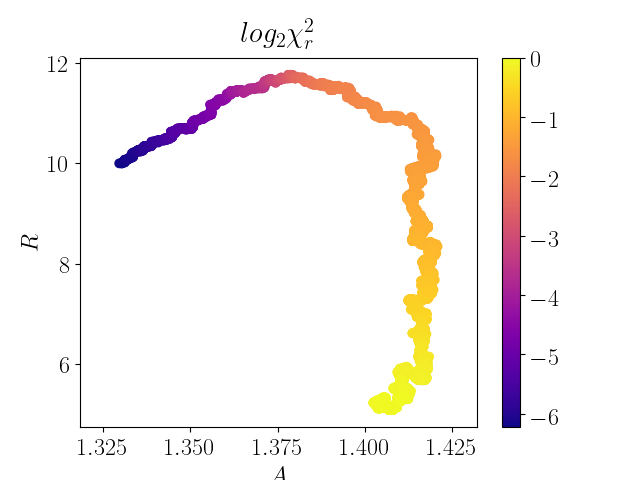

Text(0.5, 1.0, '$log_2\\chi_r^2$')

In [75]:
keyx = 'A'
keyy = 'R'

plt.figure()
# plt.plot(df[keyx],df[keyy])
plt.scatter(df[keyx],df[keyy],c=-np.log(np.array(df['r_chi2'])/chi_min)/np.log(2),cmap='plasma')
plt.colorbar()
plt.xlabel('$%s$' %keyx)
plt.ylabel('$%s$' %keyy)
plt.title(r'$log_2\chi_r^2$')

# View the fit

<IPython.core.display.Javascript object>


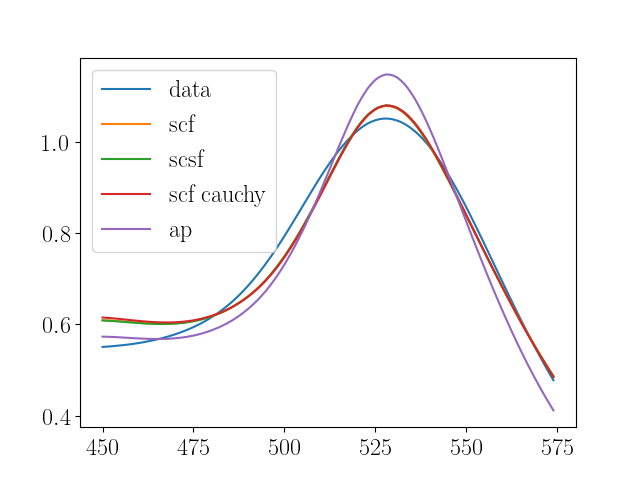

scf: 0.000756
scsf: 0.000756
scf_cauchy: 0.000862
ap: 0.002539


In [22]:
fig,ax = plt.subplots()

which_plot = 'fit'

#data
if which_plot == 'fit':
    plt.plot(lams,As,label='data')

#scf
eps_m,f,R = 2.044e+00, 2.606e-06, 5.122e+00
# eps_m,f,R = popt_scf
if which_plot == 'fit':
    plt.plot(lams,absorbance_SCf(lams,eps_m,f,R),label='scf')
else:
    plt.plot(lams,absorbance_SCf(lams,eps_m,f,R) - As,label='scf')
chi2_scf = r_chi2(absorbance_SCf,lams,As,[eps_m,f,R],ddof=len(lams))

#scsf
eps_m,f,R,e = 2.0448e+00, 2.6000e-06, 5.1760e+00, 5.6000e-02
# eps_m,f,R,e = popt_scsf
if which_plot == 'fit':
    plt.plot(lams,absorbance_SCsf(lams,eps_m,f,R,e),label='scsf')
else:
    plt.plot(lams,absorbance_SCsf(lams,eps_m,f,R,e) - As,label='scsf')
chi2_scsf = r_chi2(absorbance_SCsf,lams,As,[eps_m,f,R,e],ddof=len(lams))

#scf_cauchy
A,B,f,R = 1.4076e+00, 8.0700e+03, 2.5670e-06, 5.1220e+00
# A,B,f,R = popt_scf_cauchy
if which_plot == 'fit':
    plt.plot(lams,absorbance_SCf_cauchy(lams,A,B,f,R),label='scf cauchy')
else:
    plt.plot(lams,absorbance_SCf_cauchy(lams,A,B,f,R) - As,label='scf cauchy')
chi2_scf_cauchy = r_chi2(absorbance_SCf_cauchy,lams,As,[A,B,f,R],ddof=len(lams))\

#ap
eps_m,f = 2.0752e+00, 2.3180e-06
# eps_m,f = popt_ap
if which_plot == 'fit':
    plt.plot(lams,absorbance_ap(lams,eps_m,f),label='ap')
else:
    plt.plot(lams,absorbance_ap(lams,eps_m,f) - As,label='ap')
chi2_ap = r_chi2(absorbance_ap,lams,As,[eps_m,f],ddof=len(lams))
    
plt.legend()

print('scf: %f' %chi2_scf)
print('scsf: %f' %chi2_scsf)
print('scf_cauchy: %f' %chi2_scf_cauchy)
print('ap: %f' %chi2_ap)

# A posteriori fit

In [10]:
def log_normal(Rss, R_star,sigma):
    R_probs = np.zeros_like(Rss,dtype=float)
    for i,R in enumerate(Rss):
        R_probs[i] = np.exp(-(np.log(R*1./R_star))**2/(2*sigma**2))/R
        
    return R_probs/np.sum(R_probs)

<IPython.core.display.Javascript object>


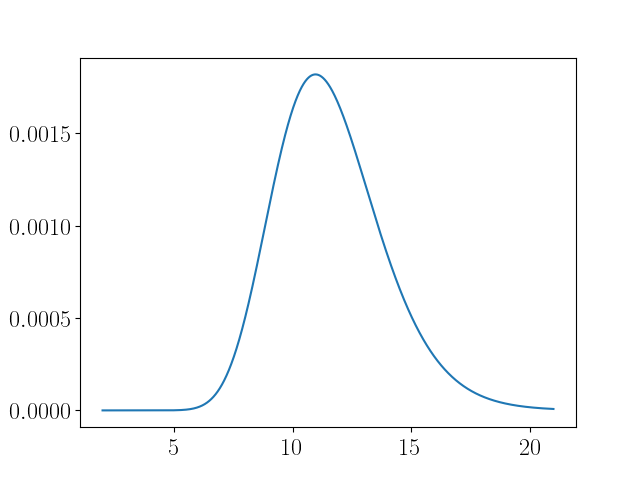

1.0000000000000002


In [37]:
Rss = np.arange(2,21,0.01)
R_probs = log_normal(Rss,11.4,0.1964)
# R_probs = log_normal(Rss,10,2)
plt.figure()
plt.plot(Rss,R_probs)
print(np.sum(R_probs))

e = 0.377

In [15]:
@np.vectorize
def absorbance_ap(lams,eps_m,f):
    return absorbance_SCf_Rdist(lams,eps_m,f,Rss,R_probs)

In [23]:
df = pd.DataFrame(data=[],columns=['eps_m','f','r_chi2'])

p0 = np.array([2,
               2e-6])
p_range = np.array([[1.7,2.5],
                    [1e-6,4e-6]])

popt,chi_min = montecarlo_descent(absorbance_ap,lams,As,p0,p_range,maxsteps=2000,save_df=df,grain=1000,T=0.0001)
chi_min = np.min(df['r_chi2'])
i_min = np.argmin(np.array(df['r_chi2']))
popt_ap = df.values[i_min][:-1]
print(popt_ap,chi_min)

100%|██████████| 2000/2000 [13:07<00:00,  2.65it/s]

[2.0752e+00 2.3180e-06] 0.0025800609690544048


In [18]:
df.to_csv('../../large_files/MCdescent_ap_T0.00001.csv')

<IPython.core.display.Javascript object>


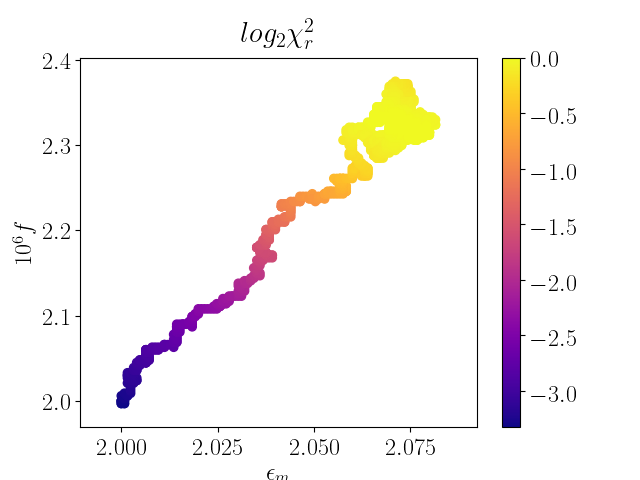

Text(0.5, 1.0, '$log_2\\chi_r^2$')

In [24]:
keyx = 'eps_m'
keyy = 'f'

plt.figure()
# plt.plot(df[keyx],df[keyy])
plt.scatter(df[keyx],10**6*df[keyy],c=-np.log(np.array(df['r_chi2'])/chi_min)/np.log(2),cmap='plasma')
plt.colorbar()
plt.xlabel(r'$\epsilon_m$')
plt.ylabel('$10^6f$')
plt.title(r'$log_2\chi_r^2$')

## Semiclassical approach for ellipse

<IPython.core.display.Javascript object>


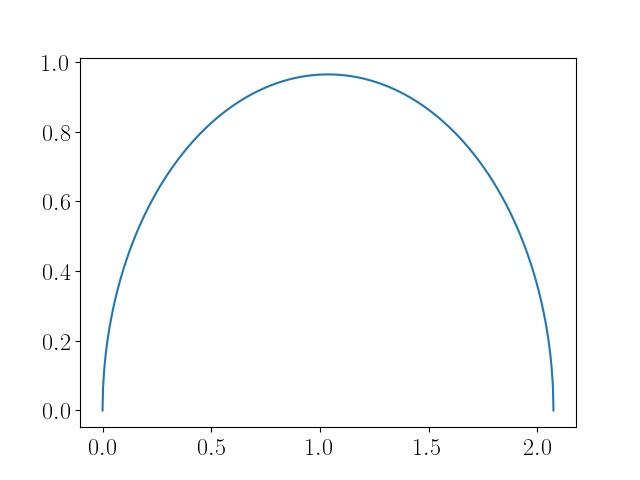

In [40]:
e = 0.37
a1 = (1 - e**2)**(-0.25)
a2 = (1 - e**2)**(0.25)

def ellipse(x):
    return a2*np.sqrt(1 - ((a1 - x)/a1)**2)

xs = np.linspace(0,2*a1,1000)

plt.figure()
plt.plot(xs,ellipse(xs))

In [41]:
def d(x):
    m = np.tan(x)
    return 2/a1/(m**2/a2**2 + 1./a1**2)*np.sqrt(1 + m**2)

factor = integrate.quad(d,0,np.pi/2)
print(factor)

(1.9746634940766594, 2.1923168770106687e-14)


In [34]:
print(np.pi/4)

0.7853981633974483
